In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

In [2]:
# preprocessing of dataset

def get_base_model():
    base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
    x = GlobalAveragePooling2D()(base.output)
    model = Model(inputs=base.input, outputs=x)
    return model

def preprocess_face(frame, face_cascade, size=(256, 256)):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    processed_faces = []

    for (x, y, w, h) in faces:
        margin = int(0.2 * w)
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(frame.shape[1], x + w + margin)
        y2 = min(frame.shape[0], y + h + margin)
        face_img = frame[y1:y2, x1:x2]
        face_resized = cv2.resize(face_img, size)
        processed_faces.append((face_resized, (x1, y1, x2, y2)))
    return processed_faces

In [3]:
# capturing data through webcam for creating dataset for each individual

def collect_data(data_dir="dataset", label="person"):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    os.makedirs(os.path.join(data_dir, label), exist_ok=True)

    cap = cv2.VideoCapture(0)
    count = 0
    print("[INFO] Press 'q' to stop capturing...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        faces = preprocess_face(frame, face_cascade)
        for face_img, (x1, y1, x2, y2) in faces:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            filename = os.path.join(data_dir, label, f"{count}.jpg")
            cv2.imwrite(filename, face_img)
            count += 1

        cv2.imshow("Collecting Faces", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"[INFO] Collected {count} images for '{label}'")

In [4]:
# creating the model for training

def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

In [12]:
# training model with data augmentation

def train_model(data_dir="dataset", model_save_path="face_model.h5"):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2,
        rotation_range=15,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    train_gen = datagen.flow_from_directory(
        data_dir, target_size=(256, 256), batch_size=16, subset="training"
    )
    val_gen = datagen.flow_from_directory(
        data_dir, target_size=(256, 256), batch_size=16, subset="validation"
    )

    model, base_model = create_model(num_classes=train_gen.num_classes)

    history = model.fit(train_gen, validation_data=val_gen, epochs=5)
    model.save(model_save_path)
    print("[INFO] Model saved as", model_save_path)
    return model, base_model, history, val_gen

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy vs Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Loss vs Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    ######
    
    

In [7]:
# generation of embeddings

def generate_embeddings(base_model, data_dir="dataset", save_path="embeddings.pkl"):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    gen = datagen.flow_from_directory(data_dir, target_size=(256, 256), class_mode='sparse', shuffle=False)

    embeddings = base_model.predict(gen)
    if len(embeddings.shape) > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
    labels = gen.classes
    label_map = {v: k for k, v in gen.class_indices.items()}

    emb_dict = {"embeddings": embeddings, "labels": labels, "label_map": label_map}
    with open(save_path, "wb") as f:
        pickle.dump(emb_dict, f)

    print("[INFO] Saved embeddings to", save_path)
    return emb_dict

In [8]:
# graph for PCA (Principle Component Analysis) of dataset

def plot_embeddings(emb_dict):
    X = emb_dict["embeddings"]
    y = emb_dict["labels"]
    label_map = emb_dict["label_map"]

    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    for label in np.unique(y):
         plt.scatter(reduced[y == label, 0], reduced[y == label, 1],
                    label=label_map[label], alpha=0.7)
    plt.legend()
    plt.title("PCA of Face Embeddings")
    plt.show()

In [9]:
# output screen, detecting faces

def recognize_faces(base_model, emb_dict, threshold=0.5):
    from sklearn.neighbors import NearestNeighbors
    import cv2
    import numpy as np

    embeddings = emb_dict['embeddings']
    labels = emb_dict['labels']
    label_map = emb_dict['label_map']

    # Flatten stored embeddings before fitting NearestNeighbors
    if len(embeddings.shape) > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(embeddings)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    cap = cv2.VideoCapture(0)
    print("[INFO] Starting real-time recognition... Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        faces = preprocess_face(frame, face_cascade)
        for face_img, (x1, y1, x2, y2) in faces:
            img_array = np.expand_dims(preprocess_input(face_img), axis=0)
            emb = base_model.predict(img_array)

            if len(emb.shape) > 2:   # flatten embedding to match stored dimension
                emb = emb.reshape(emb.shape[0], -1)

            if emb.shape[1] != embeddings.shape[1]:    # resize if needed
                emb = np.resize(emb, (emb.shape[0], embeddings.shape[1]))

            dist, idx = nbrs.kneighbors(emb)
            label = label_map[labels[idx[0][0]]]

            if dist[0][0] < threshold:
                color, text = (0, 255, 0), f"Valid ({label})"
            else:
                color, text = (0, 0, 255), "Unknown"

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.imshow('Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [13]:
# MAIN function to run program

def main():
    print("\n========== Facial Recognition Pipeline ==========")
    print("1. Collect dataset from webcam")
    print("2. Train model with data augmentation")
    print("3. Generate & visualize embeddings")
    print("4. Run real-time recognition")
    print("=================================================\n")

    choice = input("Select step to start from (1-4): ")

    if choice == "1":
        label = input("Enter label/name for person: ")
        collect_data(data_dir="dataset", label=label)
        proceed = input("Proceed to training? (y/n): ")
        if proceed.lower() != "y":
            return

    if choice in ["1", "2"]:
        model, base_model, history, val_gen = train_model("dataset")
    else:
        # Load pre-trained model if exists
        from tensorflow.keras.models import load_model
        model = load_model("face_model.h5")
        base_model = Model(inputs=model.input, outputs=model.layers[-3].output)
        print("[INFO] Loaded existing model")

    if choice in ["1", "2", "3"]:
        emb_dict = generate_embeddings(base_model, "dataset")
        plot_embeddings(emb_dict)
    else:
        import pickle
        with open("embeddings.pkl", "rb") as f:
            emb_dict = pickle.load(f)
        print("[INFO] Loaded saved embeddings")

    print("\n[INFO] Starting real-time recognition...")
    recognize_faces(base_model, emb_dict)
    
    plot_training_history(history)
    
    print("[INFO] Generating confusion matrix...")
    val_gen.reset()
    Y_pred = model.predict(val_gen)
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(val_gen.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix - Validation Data", fontsize=14)
    plt.grid(False)
    plt.show()


========== Facial Recognition Pipeline ==========
1. Collect dataset from webcam
2. Train model with data augmentation
3. Generate & visualize embeddings
4. Run real-time recognition



Select step to start from (1-4):  2


Found 1452 images belonging to 3 classes.
Found 362 images belonging to 3 classes.


C:\Users\Sarvesh Baskaran\AppData\Local\Temp\ipykernel_7100\933820671.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))


Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.9201 - loss: 0.3182 - val_accuracy: 0.9862 - val_loss: 0.1591
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 405ms/step - accuracy: 0.9952 - loss: 0.0514 - val_accuracy: 0.9890 - val_loss: 0.0777
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 418ms/step - accuracy: 0.9986 - loss: 0.0227 - val_accuracy: 0.9945 - val_loss: 0.0391
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 421ms/step - accuracy: 0.9979 - loss: 0.0149 - val_accuracy: 0.9917 - val_loss: 0.0407
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9945 - val_loss: 0.0307


[INFO] Model saved as face_model.h5
Found 1814 images belonging to 3 classes.
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 562ms/step
[INFO] Saved embeddings to embeddings.pkl


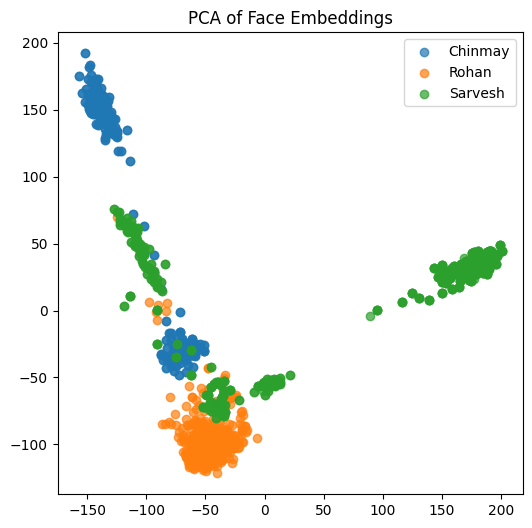


[INFO] Starting real-time recognition...
[INFO] Starting real-time recognition... Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


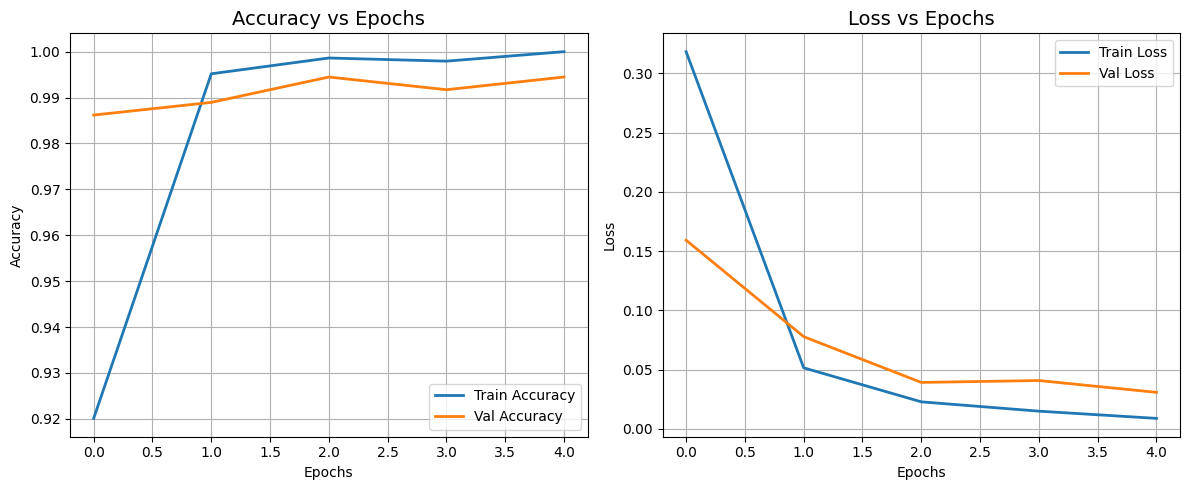

[INFO] Generating confusion matrix...
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step


<Figure size 800x600 with 0 Axes>

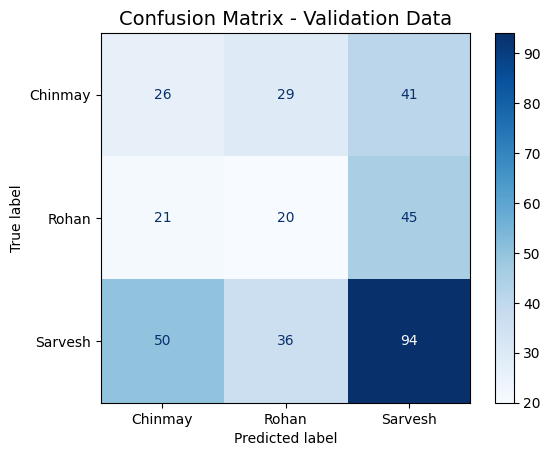

In [15]:
if __name__ == "__main__":
    main()